# 4-9-Pink-Simple Sequence-to-Sequence Model for Streamflow Prediction with Covariates and Attention

This notebook captures the workflow for a simple attention sequence-to-sequence network with Luong's Global Attention, to predict streamflow at all validated California sensors. 


## Setup Pytorch and Packages

In [31]:
!pip install pkbar
!pip install plotly

In [32]:
!pip install wandb
!wandb login

wandb: Currently logged in as: carolwu (use `wandb login --relogin` to force relogin)


In [33]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pkbar
import plotly
import plotly.graph_objects as go
import zipfile
import seaborn as sns
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
import wandb

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

## Setup some notebook constants

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:

RAW_DATASET_LOCATION = '/content/drive/My Drive/water_challenge/merged_climate_4km_water.zip'
RAW_DATASET_FILENAME = 'merged_climate_4km_water.csv'
CHECKPOINT_NAME = 'simple_seq2seq_covariates_attention.tar'
CHECKPOINT_DIRECTORY = '/content/drive/My Drive/water_challenge'
WATER_STATION_FP = '/content/drive/My Drive/water_challenge/water_station_master_data/water_stations_master_data.csv'
WATER_STREAMFLOW_FP = '/content/drive/My Drive/water_challenge/merged_climate_4km_water.zip'

## Preprocess data

The goal is to create a pytorch DataLoader that we can feed into the training and testing of our models. A DataLoader is the preferred method for passing 
data to a model training loop, because if setup properly, a DataLoader can "lazily" load the data and avoid overwhelming the computer's memory. 
 

### Load data

This code below will load the data and setup a clean dataframe with all of the sensor data. 

                  lat     lon   tmmx   tmmn  ...   vpd   vs   site_no  Streamflow
Date                                         ...                                 
1979-09-16  38.941667 -122.85  310.4  289.2  ...  3.08  4.4  11449500         2.4
1979-09-17  38.941667 -122.85  308.4  286.9  ...  2.79  2.9  11449500         2.4
1979-09-18  38.941667 -122.85  303.5  283.1  ...  1.70  2.8  11449500         2.5
1979-09-19  38.941667 -122.85  303.3  279.2  ...  1.51  4.7  11449500         2.5
1979-09-20  38.941667 -122.85  306.6  282.2  ...  2.16  4.9  11449500         2.6

[5 rows x 21 columns]


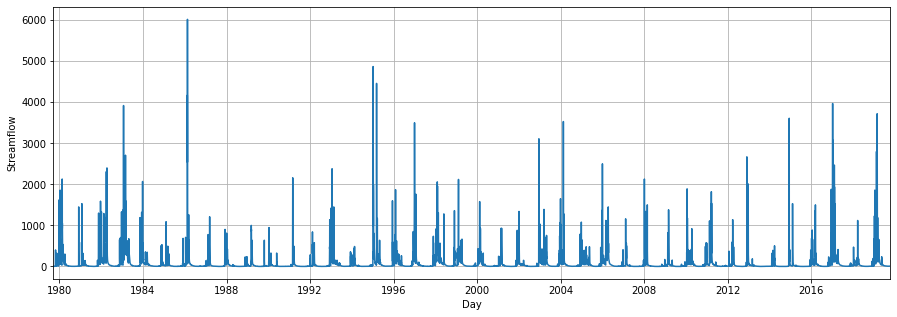

(14639, 21)

In [36]:
# download the data file from google drive
# load the data into memory

df = pd.read_csv(RAW_DATASET_LOCATION,
                 compression='zip',
                 index_col='Date',
                 parse_dates=True) 

# filter out unneeded columns, and filter to only include sensor 11180500.
df = df.drop(['Unnamed: 0'], axis=1)

df = df[df['site_no'].isin(['11449500'])]

# show what the data looks like. 
print(df.head())


def plot_data(df):
    plt.title('')
    plt.ylabel('Streamflow')
    plt.xlabel('Day')
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.plot(df['Streamflow'])
    plt.show()

plot_data(df)

df.shape

### Split the data into training and test sets

Note that I added some new columns to the dataframe `df` to include year, month, day, and week values. I converted all variables to float type, to allow for differentiation. 


In [37]:

def add_covariates(df):
  df['year'] = df.index.year.values.astype(float)
  df['month'] = df.index.month.values.astype(float)
  df['day'] = df.index.day.values.astype(float)
  df['week'] = df.index.isocalendar().week.values.astype(float)

  df.loc[:, 'year'] = stats.zscore(df.loc[:, 'year'])  
  df.loc[:, 'month'] = stats.zscore(df.loc[:, 'month'])
  df.loc[:, 'day'] = stats.zscore(df.loc[:, 'day'])
  df.loc[:, 'week'] = stats.zscore(df.loc[:, 'week'])

  df.loc[:, 'Streamflow'] = df.loc[:, 'Streamflow'].values.astype(float)
  return df

df = add_covariates(df)

df.shape

(14639, 25)

In [38]:
test_data_size = 365

train_data = df[:-test_data_size]
test_data = df[-2*test_data_size:]  #Length of test data: 730
train_data = train_data.loc[:, ['Streamflow', 'pr', 'tmmx', 'year', 'month', 'day', 'week']]
test_data = test_data.loc[:, ['Streamflow', 'pr', 'tmmx', 'year', 'month', 'day', 'week']]

print(f'Length of training data: {len(train_data)}')
print(f'Length of test data: {len(test_data)}')

train_data.shape
train_data

Length of training data: 14274
Length of test data: 730


,Streamflow,pr,tmmx,year,month,day,week
Date,,,,,,,
1979-09-16,2.40,0.0,310.4,-1.749134,0.716734,0.030770,0.689677
1979-09-17,2.40,0.0,308.4,-1.749134,0.716734,0.144406,0.756091
1979-09-18,2.50,0.0,303.5,-1.749134,0.716734,0.258041,0.756091
1979-09-19,2.50,0.0,303.3,-1.749134,0.716734,0.371676,0.756091
1979-09-20,2.60,0.0,306.6,-1.749134,0.716734,0.485311,0.756091
...,...,...,...,...,...,...,...
2018-10-10,4.75,0.0,295.8,1.620362,1.006769,-0.651040,0.955330
2018-10-11,4.84,0.0,295.8,1.620362,1.006769,-0.537405,0.955330
2018-10-12,4.88,0.0,299.6,1.620362,1.006769,-0.423770,0.955330


### Rescale the data and generate windowed sequences

In [39]:
scaler = MinMaxScaler(feature_range=(-1, 1))

train_data.loc[:, 'Streamflow'] = scaler.fit_transform(train_data['Streamflow'].to_numpy()[:, np.newaxis])
test_data.loc[:, 'Streamflow'] = scaler.transform(test_data['Streamflow'].to_numpy()[:, np.newaxis])

train_data.loc[:, 'pr'] = scaler.fit_transform(train_data['pr'].to_numpy()[:, np.newaxis])
test_data.loc[:, 'pr'] = scaler.transform(test_data['pr'].to_numpy()[:, np.newaxis])

train_data.loc[:, 'tmmx'] = scaler.fit_transform(train_data['tmmx'].to_numpy()[:, np.newaxis])
test_data.loc[:, 'tmmx'] = scaler.transform(test_data['tmmx'].to_numpy()[:, np.newaxis])

train_data_normalized = train_data

test_data_normalized = test_data

test_data_normalized.shape


(730, 7)

In [40]:
# Convert to tensor
train_data_normalized = torch.FloatTensor(train_data_normalized.to_numpy())
test_data_normalized = torch.FloatTensor(test_data_normalized.to_numpy())

# Slice windows for the data
train_window = 365     # take in 365 days
output_window = 365    # predict 365 days

def create_inout_sequences(data, training_window_length, label_length):
    sequences = []
    L = len(data)
    for i in range(L-(training_window_length + label_length)):
        train_seq = data[i:(i+training_window_length)]
        train_label = data[(i+training_window_length):(i+training_window_length+label_length)]
        sequences.append((train_seq, train_label))
    return sequences

# After chop out the data, we will have row(bath size=64), col(365 days), 7 variables

#import pdb; pdb.set_trace()
train_inout_seq = create_inout_sequences(train_data_normalized, train_window, output_window)
test_inout_seq = create_inout_sequences(test_data_normalized, train_window, output_window)
#print(train_inout_seq[100])
#print(train_inout_seq.numpy())

In [41]:
test_inout_seq = create_inout_sequences(test_data_normalized, train_window, output_window)
len(test_inout_seq)


0

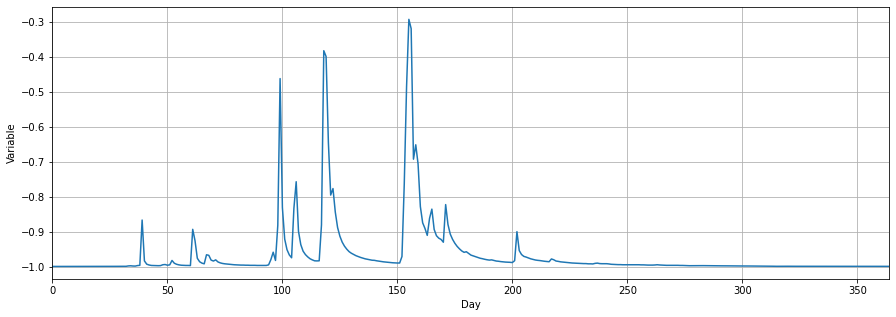

In [42]:
def plot_data_tensor(data_tensor):
    plt.title('')
    plt.ylabel('Variable')
    plt.xlabel('Day')
    plt.grid(True)
    plt.autoscale(axis='x',tight=True)
    plt.plot(data_tensor[0][0][:,0])
    plt.show()
plot_data_tensor(train_inout_seq)

### Setup template for DataLoader

In [43]:
class AlamedaDataset(Dataset):
  def __init__(self, sequence_array, training_window, transform=None, train=True):
    self.sequence_array = sequence_array # can substitute with create_inout_seq() function
    self.training_window = train_window
    self.transform = transform
    self.train = train

  def __len__(self):
    if self.train:
      return len(self.sequence_array) - self.training_window
    else:
      return len(self.sequence_array)
 
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    seq, label = self.sequence_array[idx]
    #print(seq.shape)
    #print(label.shape)
    return (seq, label)   # seq=[365,7],label=[365,7]



### Check if the Dataloader works

We can check whether our DataLoader works. We will use the same DataLoader, but with different settings for our actual model training.

In [44]:
d_train = AlamedaDataset(train_inout_seq, train_window, train=True)
train_loader = DataLoader(dataset=d_train)
print(len(train_loader))

13179


## Setting up the Attention Encoder-Decoder Model



### Setup the Encoder
This is a simple LSTM layer to encode the features.
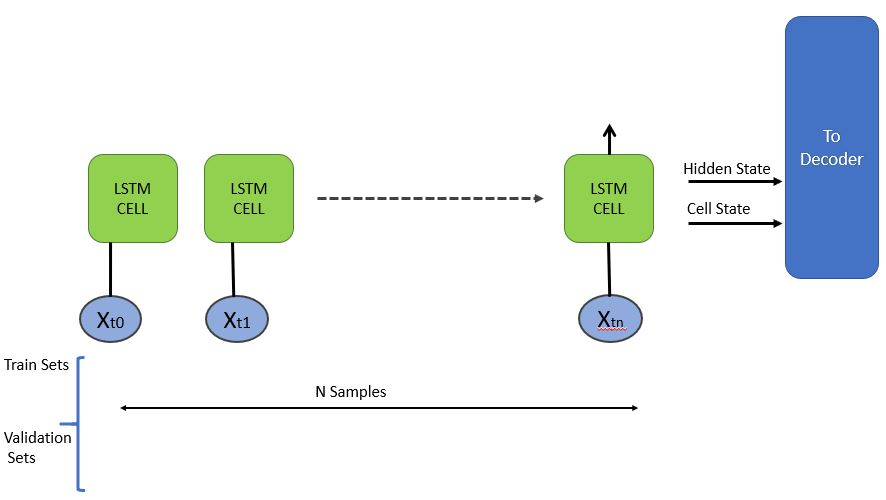

In [45]:
class Encoder(nn.Module):
  def __init__(self, n_features, 
               hidden_dim, 
               num_layers, 
               dropout=0.0,
               debug=False):
    
    super(Encoder, self).__init__()

    self.debug = debug

    if self.debug:
        assert (n_features > 0), "number of features must be greater than zero."
        assert (hidden_dim > 0), "hidden dimension must be greater than zero."
        assert (num_layers > 0), "number of layers must be greater than zero."

    self.input_dim = n_features  # input shape
    self.hidden_dim = hidden_dim  # number of nodes in hidden layer
    self.num_layers = num_layers  # number of stacked network layers
    self.dropout_percentage = dropout

    self.lstm1 = nn.LSTM(
          input_size=n_features,
          hidden_size=hidden_dim,
          num_layers=num_layers,
          batch_first=True,
          bidirectional=False,
          dropout = self.dropout_percentage
          )

  def forward(self, x):

    # x will have shape [batch_size, sequence_length, num_features]
    if self.debug:
        assert (x.shape[2] == self.input_dim), f"Error: Encoder input X. X should have {self.input_dim} features but only has {x.shape[2]}."

    outputs, (hidden, cell) = self.lstm1(x)  # will take in [batch, sequence_length, input_size], (hidden, cell)
   # print(outputs.shape)
   # print(hidden.shape)
   # print(cell.shape)
   # outputs=([64, 365, 128]) hidden=([2, 64, 128]) cell= ([2, 64, 128])
    return outputs, hidden, cell 


### Setup the Attention layer

In [46]:
class Attention(nn.Module):
    def __init__(self, method, hidden_size, debug=False):
        super(Attention, self).__init__()
        self.method = method
        if self.method not in ['dot', 'general', 'concat']:
            raise ValueError(self.method, "is not an appropriate attention method.")
        self.hidden_size = hidden_size
        if self.method == 'general':
            self.attn = nn.Linear(self.hidden_size, hidden_size)
        elif self.method == 'concat':
            self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
            self.v = nn.Parameter(torch.FloatTensor(hidden_size))

    def dot_score(self, hidden, encoder_output):
        return torch.sum(torch.mul(hidden, encoder_output), dim=2)

    def general_score(self, hidden, encoder_output):
        energy = self.attn(encoder_output)
        return torch.sum(torch.mul(hidden, energy), dim=2)

    def concat_score(self, hidden, encoder_output):
        energy = self.attn(torch.cat((hidden.expand(encoder_output.size(0), -1, -1), encoder_output), 2)).tanh()
        return torch.sum(torch.mul(self.v, energy), dim=2)

    def forward(self, hidden, encoder_outputs):
        # Calculate the attention weights (energies) based on the given method
        if self.method == 'general':
            attn_energies = self.general_score(hidden, encoder_outputs)
        elif self.method == 'concat':
            attn_energies = self.concat_score(hidden, encoder_outputs)
        elif self.method == 'dot':
            attn_energies = self.dot_score(hidden, encoder_outputs)

        # Return the softmax normalized probability scores (with added dimension)
        return F.softmax(attn_energies, dim=1).unsqueeze(1)

### Decoder

In [47]:
class Decoder(nn.Module):
  def __init__(self, 
               n_features, 
               hidden_dim, 
               num_layers, 
               output_size, 
               attention, 
               dropout=0.0,
               debug=False):

    super(Decoder, self).__init__()

    self.attention = attention
    self.debug = debug
    if self.debug:
        assert (output_size <= n_features), "The output size has to be smaller than the number of features."


    self.lstm1 = nn.LSTM(
        input_size=n_features,
        hidden_size=hidden_dim,
        num_layers=num_layers,
        batch_first=True,
        dropout = dropout
        )
    self.out = nn.Linear(hidden_dim, output_size)
    self.concat = nn.Linear(hidden_dim * 2, hidden_dim)

  def forward(self, x, hidden, cell, encoder_outputs):

    if self.debug:
        assert (x.shape[1] == 1), "The input tensor X must have 1 as the second dimension, like [64, 1, 14]. The hidden state is just a vector."

    #import pdb; pdb.set_trace() 
    lstm_outputs, (hidden, cell) = self.lstm1(x, (hidden,cell))  # x must be [batch, sequence_len, input_size]

    attn_weights = self.attention(lstm_outputs, encoder_outputs)  
    # We take all the previous information and use decoder lstm to predict the next 1 days. Note: encoder lstm predict 365 day in a row

    # Multiplying Attention weights with encoder outputs to get context vector
    context = attn_weights.bmm(encoder_outputs) # normalization fo the attn_weights

    lstm_outputs = lstm_outputs.squeeze(1)
    context = context.squeeze(1)
    concat_input = torch.cat((lstm_outputs, context), 1)
    concat_output = torch.tanh(self.concat(concat_input))
    # Predict next word using Luong eq. 6
    output = self.out(concat_output)
    output = F.softmax(output, dim=1)
    # Return output and final hidden state
    # output=([64, 3]), hidden=([2, 64, 128]), cell=([2, 64, 128])
    return output, hidden, cell 

### Sequence-2-Sequence


In [48]:
class Seq2Seq(nn.Module):

  def __init__(self, encoder, decoder, seq2seq_output_dim, decoder_output_dim, debug=False):
    super(Seq2Seq, self).__init__()

    self.seq2seq_output_dim = seq2seq_output_dim
    self.decoder_output_dim = decoder_output_dim
    self.encoder = encoder
    self.decoder = decoder
    self.debug = debug

    if self.debug:
        assert (self.seq2seq_output_dim > 0), "Fill in the message"
        assert (self.decoder_output_dim >0), "Fill in the second message."        

  def forward(self, src, target, teacher_force_ratio=0.35):

    if self.debug:
        assert (self.seq2seq_output_dim > 0), "Fill in the message"
        assert (self.decoder_output_dim >0), "Fill in the second message."        

    # scr =[64, 365, 7], target= [64, 365, 7]
    batch_size = src.shape[0]    
    target_len = target.shape[1]  

    outputs = torch.zeros(batch_size, target_len, self.seq2seq_output_dim).to(device)

    encoder_outputs, hidden, cell = self.encoder(src)  #Note: the encoder return outputs=([64, 365, 128]), hidden=([2, 64, 128]), cell= ([2, 64, 128])
    #import pdb; pdb.set_trace()

    # collect all the encoder information
    x = src[:, -1, :].unsqueeze(1)  # innitial the last value of scr data
    
    for t in range(1, target_len):

      output, hidden, cell = self.decoder(x, hidden, cell, encoder_outputs)
      #import pdb; pdb.set_trace()
      outputs[:, t, :] = output 
      #outputs[:, t, 0:self.decoder_output_dim] = output.squeeze(1)
      #outputs[:, t, self.decoder_output_dim:] = target[:, t, self.decoder_output_dim:]  # saves categorical info back to outputs. 
      # Now, outputs=[64, 365, 7], before outputs=[64, 365, 3]

      if random.random() < teacher_force_ratio:
        x = target[:, t, :].unsqueeze(1)
      else:
        x = outputs[:, t, :].clone().unsqueeze(1)

    return outputs


Setup the checkpointing functions

In [49]:
def save_checkpoint(state, filename="my_checkpoint.tar"):
    print('=> Saving checkpoint')
    directory = CHECKPOINT_DIRECTORY
    filename = os.path.join(directory, filename)
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print('=> Loading model from checkpoint')
    model.load_state_dict(checkpoint['state_dict']) # this is dirty to touch global state. 
    optimizer.load_state_dict(checkpoint['optimizer'])

# Setup sweep config

In [50]:
sweep_config = {
    'method': 'random',
    'metric': {
      'name': 'loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'hidden_size': {
            'values': [64, 128, 256]
        },
        'enc_dropout': {
            'values': [0.1,0.2]
        },
        'dec_dropout': {
            'values': [0.1,0.2]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4]
        },
        'num_layers':{
            'values':[1]
        },
        'optimizer': {
            'values': ['adam', 'sgd']
        },
    }
}


In [51]:
sweep_id = wandb.sweep(sweep_config, project="4-9-Pink Floyd")

Create sweep with ID: a6ol5682
Sweep URL: https://wandb.ai/carolwu/4-9-Pink%20Floyd/sweeps/a6ol5682


In [52]:
num_features = 7 # number of features, meaning number of columns.
sequence_length = 365 # the length of the sequence of values.[1, 2, 3, 4, 5 ...] --> 5 length.
num_layers = 1
hidden_size = 128 # number of hidden nodes in each timestep
decoder_output_dim = 3    # predicting Streamflow, precipitation, and temperature
output_size = 7  # predicting Streamflow, precipitation, and temperature
enc_dropout = 0.35
dec_dropout = 0.35
learning_rate = 0.001
batch_size = 64
epochs = 40

d_train = AlamedaDataset(train_inout_seq, train_window, train=True)
print(len(d_train))
train_loader = DataLoader(dataset=d_train, batch_size=batch_size, shuffle=True)
batches_per_epoch = len(train_loader.dataset)//batch_size

13179


In [53]:
use_cuda = torch.cuda.is_available()
print("Is CUDA available? %s.", use_cuda)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA available? %s. True


In [54]:
def train():
    # Default values for hyper-parameters we're going to sweep over
    # num_epochs = 100
    
    config_defaults = {
        'hidden_size': 64,
        'enc_dropout': 0.35,
        'dec_dropout': 0.35,
        'learning_rate': 1e-3,
        'num_layers': 1,
        'optimizer': 'adam',
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # set up models
    attn = Attention("dot", config.hidden_size) 

    encoder_net = Encoder(
        num_features, 
        config.hidden_size, 
        config.num_layers, 
        dropout = config.enc_dropout
    ).to(device)

    decoder_net = Decoder(
        num_features,
        config.hidden_size,
        config.num_layers,
        output_size,
        attn,
        dropout = config.dec_dropout,
    ).to(device)

    model = Seq2Seq(encoder_net, decoder_net,num_features, decoder_output_dim).to(device)

    criterion = torch.nn.MSELoss()
    
    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = torch.optim.SGD(model.parameters(),lr=config.learning_rate, momentum=0.9)
    elif config.optimizer=='adam':
      optimizer = torch.optim.Adam(model.parameters(),lr=config.learning_rate)
    
    # print(model)

    # d_train = AlamedaDataset(train_inout_seq, train_window, train=True)
    # # print(len(d_train))
    # train_loader = DataLoader(dataset=d_train, batch_size=batch_size, shuffle=True)
    # batches_per_epoch = len(train_loader.dataset)//batch_size

    # load_from_checkpoint = True

    # if load_from_checkpoint:
    #     load_checkpoint(torch.load(os.path.join(CHECKPOINT_DIRECTORY, CHECKPOINT_NAME)),model)
    model.train()
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}/{epochs}")
        kbar = pkbar.Kbar(target=batches_per_epoch, width=8)
        # if epoch % 5 == 0:
        #   checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
        #   save_checkpoint(checkpoint, CHECKPOINT_NAME)
        closs= 0
        for batch_idx, (data, targets) in enumerate(train_loader):
            # Get data to cuda if possible
            data = data.to(device).squeeze(-1) # remove 1 on the axis.
            targets = targets.to(device)
            
            #print(data.shape)
            # forward pass and compute error
            #import pdb; pdb.set_trace()
            scores = model(data, targets)
            loss = criterion(scores, targets)

            # backward pass and apply gradients.
            optimizer.zero_grad()
            loss.backward()
            closs = closs + loss.item()
            # gradient descent step
            optimizer.step()
            kbar.update(batch_idx, values=[("loss", loss)])
            wandb.log({"batch loss":loss.item()})
        wandb.log({"loss":closs/batch_size}) 

In [55]:
#wandb.agent(sweep_id, train)

# Train again with best hyperparameters

In [56]:
use_cuda = torch.cuda.is_available()
print("Is CUDA available? %s.", use_cuda)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_features = 7 # number of features, meaning number of columns.
sequence_length = 365 # the length of the sequence of values.[1, 2, 3, 4, 5 ...] --> 5 length.
num_layers = 1
hidden_size = 128 # number of hidden nodes in each timestep
output_size = 7  # predicting Streamflow, precipitation, and temperature
enc_dropout = 0.2
dec_dropout = 0.1
learning_rate = 0.001
batch_size = 64
num_epochs = 100
decoder_output_dim = 3    # predicting Streamflow, precipitation, and temperature


attn = Attention("dot", hidden_size) 

encoder_net = Encoder(
    num_features, 
    hidden_size, 
    num_layers, 
    dropout = enc_dropout
).to(device)

decoder_net = Decoder(
    num_features,
    hidden_size,
    num_layers,
    output_size,
    attn,
    dropout = dec_dropout,
).to(device)

d_train = AlamedaDataset(train_inout_seq, train_window, train=True)
print(len(d_train))
train_loader = DataLoader(dataset=d_train, batch_size=batch_size, shuffle=True)

model = Seq2Seq(encoder_net, decoder_net,num_features, decoder_output_dim).to(device)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
batches_per_epoch = len(train_loader.dataset)//batch_size

print(model)

Is CUDA available? %s. True
13179
Seq2Seq(
  (encoder): Encoder(
    (lstm1): LSTM(7, 128, batch_first=True, dropout=0.2)
  )
  (decoder): Decoder(
    (attention): Attention()
    (lstm1): LSTM(7, 128, batch_first=True, dropout=0.1)
    (out): Linear(in_features=128, out_features=7, bias=True)
    (concat): Linear(in_features=256, out_features=128, bias=True)
  )
)


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:63: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1



In [57]:
load_from_checkpoint = False

if load_from_checkpoint:
    load_checkpoint(torch.load(os.path.join(CHECKPOINT_DIRECTORY, CHECKPOINT_NAME)),model)


for epoch in range(num_epochs):
    print(f"Epoch: {epoch + 1}/{num_epochs}")
    kbar = pkbar.Kbar(target=batches_per_epoch, width=8)

    if epoch % 5 == 0:
      checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
      save_checkpoint(checkpoint, CHECKPOINT_NAME)

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device).squeeze(-1) # remove 1 on the axis.
        targets = targets.to(device=device)
        
        #print(data.shape)
        # forward pass and compute error
        #import pdb; pdb.set_trace()
        scores = model(data, targets)
        loss = criterion(scores, targets)

    # backward pass and apply gradients.
        optimizer.zero_grad()
        loss.backward()

        # gradient descent step
        optimizer.step()

        kbar.update(batch_idx, values=[("loss", loss)])

Epoch: 1/100
=> Saving checkpoint
205/205 [========] - 115s 559ms/step - loss: 0.7401
Epoch: 2/100
205/205 [========] - 115s 560ms/step - loss: 0.7010
Epoch: 3/100
205/205 [========] - 115s 563ms/step - loss: 0.6979
Epoch: 4/100
205/205 [========] - 116s 566ms/step - loss: 0.6956
Epoch: 5/100
205/205 [========] - 115s 563ms/step - loss: 0.6944
Epoch: 6/100
=> Saving checkpoint
205/205 [========] - 116s 564ms/step - loss: 0.6924
Epoch: 7/100
205/205 [========] - 116s 564ms/step - loss: 0.6926
Epoch: 8/100
205/205 [========] - 116s 563ms/step - loss: 0.6920
Epoch: 9/100
205/205 [========] - 116s 564ms/step - loss: 0.6908
Epoch: 10/100
205/205 [========] - 115s 563ms/step - loss: 0.6910
Epoch: 11/100
=> Saving checkpoint
205/205 [========] - 116s 565ms/step - loss: 0.6911
Epoch: 12/100
205/205 [========] - 115s 562ms/step - loss: 0.6904
Epoch: 13/100
205/205 [========] - 115s 562ms/step - loss: 0.6905
Epoch: 14/100
205/205 [========] - 115s 562ms/step - loss: 0.6899
Epoch: 15/100
205/205 

# Generate predictions from the model on the test set

In [58]:
fut_pred = 365

# This will take the array and make it into a list. The 
# length of the list is the last 365 observations. I am 
# going to make a rolling window forward as I append predictions 
# to this list and then predict on the resulting output. 
# I am using a list here because it is like a vector that can keep growing. 

test_inputs = test_data.values.tolist()
forecast_inputs = test_data_normalized.tolist()
print(forecast_inputs[-fut_pred])


def generate_predictions(prediction_window, data, model):

    model.eval()
    # for i in range(prediction_window):
    seq = torch.FloatTensor(data[:prediction_window])
    seq_target = torch.FloatTensor(data[-prediction_window:])
    seq = seq[np.newaxis, :]
    seq_target = seq_target[np.newaxis,:]
    # print(seq.shape)
    # print(seq_target.shape)
    # break
    #import pdb; pdb.set_trace()
    pred = 0
    with torch.no_grad():
      seq = seq.to(device)
      seq_target = seq_target.to(device)
      result = model(seq, seq_target)
      # print(result.shape)
      # print(len(data))
      # result.tolist()[0]
      pred = result.tolist()[0]
    # model.train()   
    return pred     

pred_365 = generate_predictions(fut_pred, forecast_inputs, model)
print(pred_365)

[-0.9985946416854858, -1.0, 0.1483870893716812, 1.6203616857528687, 1.0067685842514038, -0.08286454528570175, 1.0217430591583252]
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [7.190813482854663e-12, 3.2761911239465036e-11, 4.19887754787851e-07, 0.6786706447601318, 0.14396809041500092, 2.560009590979462e-07, 0.1773606240749359], [3.692302540103665e-12, 1.7337629595881587e-11, 4.6085108351689996e-07, 0.6809588670730591, 0.14123700559139252, 3.452994974395551e-07, 0.1778033971786499], [3.474984622969801e-12, 1.2918622768753885e-11, 4.866059839514492e-07, 0.6572888493537903, 0.1475580781698227, 4.4991463710175594e-07, 0.195152148604393], [4.49825897017031e-12, 1.21170252651015e-11, 5.819856596644968e-07, 0.680327296257019, 0.13342371582984924, 7.608280157000991e-07, 0.18624767661094666], [5.441365674013765e-12, 8.652099002526281e-12, 9.271806789001857e-07, 0.679736852645874, 0.1270904839038849, 2.2535100470122416e-06, 0.1931694895029068], [8.088707655062866e-12, 8.4198654992651e-12, 1.39996939196

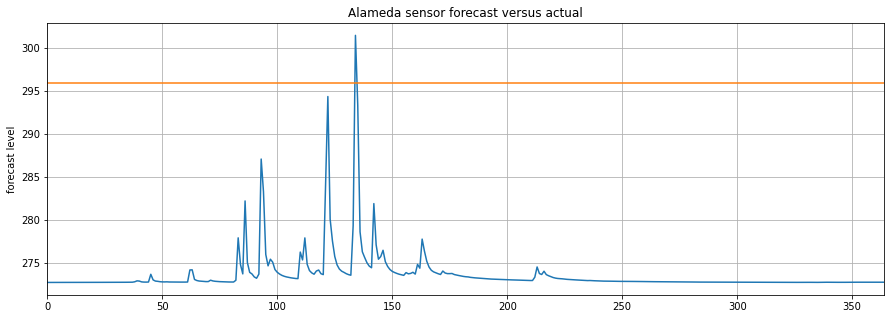

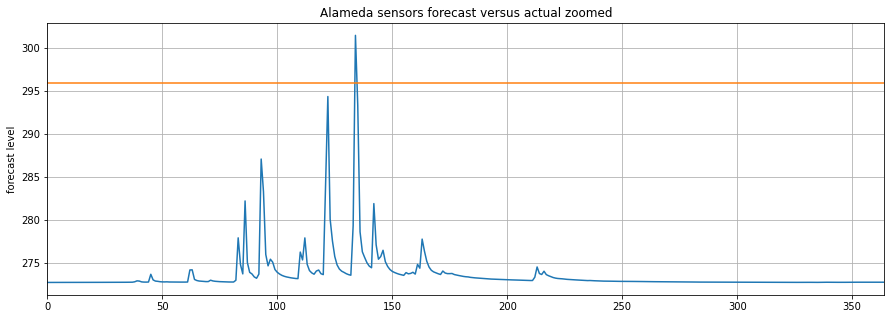

In [59]:
# remove normalization to return to original units.

predictions = scaler.inverse_transform(np.array([i[0] for i in pred_365]).reshape(-1, 1))
true_flow = scaler.inverse_transform(np.array([i[0] for i in test_inputs[-train_window:]]).reshape(-1,1))
#print(actual_predictions)

# plot the output predictions against the original data. 

# x = np.arange(132, 144, 1)
# print(x)

def plot_original_predicted():
    plt.title('Alameda sensor forecast versus actual')
    plt.ylabel('forecast level')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)
    plt.plot(true_flow)
    plt.plot(predictions)
    plt.show()


# plot zoomed in view
def plot_zoomed_original_predicted():
    plt.title('Alameda sensors forecast versus actual zoomed')
    plt.ylabel('forecast level')
    plt.grid(True)
    plt.autoscale(axis='x', tight=True)

    plt.plot(true_flow)
    plt.plot(predictions)
    plt.show()

plot_original_predicted()
plot_zoomed_original_predicted()

In [60]:
def plotly_original_predicted():
  xvals = np.arange(0, len(true_flow))
  pred = np.asarray(predictions).reshape(-1)
  actual = np.asarray(true_flow).reshape(-1)
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=xvals, y=actual,
                    mode='lines',
                    name='actual data'))
  fig.add_trace(go.Scatter(x=xvals, y=pred,
                    mode='lines',
                    name='predictions'))
  fig.update_layout(title='Alameda sensor forecast versus actual',
                   xaxis_title='Day',
                   yaxis_title='Streamflow')
  fig.show()


def plotly_zoomed_original_predicted():
  xvals = np.arange(0, len(true_flow))
  pred = np.asarray(predictions).reshape(-1)
  actual = np.asarray(true_flow).reshape(-1)
  fig = go.Figure()
  fig.add_trace(go.Scatter(x=xvals, y=actual,
                    mode='lines',
                    name='actual data'))
  fig.add_trace(go.Scatter(x=xvals, y=pred,
                    mode='lines',
                    name='predictions'))
  fig.update_layout(title='Zoomed Alameda sensor forecast versus actual',
                   xaxis_title='Day',
                   yaxis_title='Streamflow')
  fig.show() 


plotly_original_predicted()
plotly_zoomed_original_predicted()